In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [0]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg19 import VGG19

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [0]:
def content_loss(content, generated):
    return backend.sum(backend.square(generated - content))

In [0]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [0]:
def style_loss(style, generated,height,width):
    channels = 3
    G=gram_matrix(style)
    S=gram_matrix(generated)
    y=backend.sum(backend.square(G - S))
    x=4*((channels*height * width)**2)
    return y / x

In [0]:
def total_cost(J_content, J_style, alpha, beta ):
    return alpha * J_content + beta * J_style

In [0]:
def generate_noise_image(content,height,width, noise_ratio = 0.6):

    noise_image = np.random.uniform(-20, 20, (1, height, width, 3)).astype('float32')

    input_image = noise_image * noise_ratio + content * (1 - noise_ratio)
    
    return input_image

In [0]:
content_image = Image.open('camp-nou.jpg')
content_array = np.asarray(content_image, dtype= 'float32')
content_array = np.expand_dims(content_array, axis=0)
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]
_,height,width,channel=content_array.shape

In [30]:
style_image_path = '02.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_array = np.asarray(style_image, dtype= 'float32')
style_array = np.expand_dims(style_array, axis=0)
style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]
print(style_array.shape)

(1, 300, 400, 3)


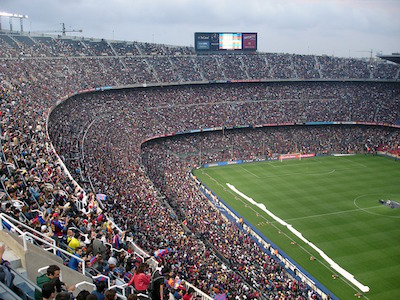

In [31]:
content_image

%cd ../

In [0]:
feature_layers = ['block1_conv2', 'block2_conv2', 
                  'block3_conv3', 'block4_conv3', 
                  'block5_conv3']

In [0]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
generated_image = backend.placeholder((1, height, width, 3))

In [0]:
input_tensor = backend.concatenate([content_image, style_image, generated_image], axis = 0)

In [0]:
model = VGG19(input_tensor=input_tensor, weights='imagenet', include_top = False)

layers = dict([(layer.name, layer.output) for layer in model.layers])

In [36]:
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_1/Relu:0' shape=(3, 300, 400, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_1/Relu:0' shape=(3, 300, 400, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_1/MaxPool:0' shape=(3, 150, 200, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_1/Relu:0' shape=(3, 150, 200, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_1/Relu:0' shape=(3, 150, 200, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_1/MaxPool:0' shape=(3, 75, 100, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_1/Relu:0' shape=(3, 75, 100, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_1/Relu:0' shape=(3, 75, 100, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_1/Relu:0' shape=(3, 75, 100, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4_1/Relu:0' shape=(3, 75, 100, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_1/MaxPool:0' shape=(3, 37, 50, 256) 

In [0]:
alpha = 2
beta = 5.0
total_variation_weight = 1.0
content_weight = 0.025
style_weight = 0.2
J_style = backend.variable(0.)

In [0]:
layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
generated_features = layer_features[2, :, :, :]

In [0]:
J_content = content_weight*content_loss(content_image_features, generated_features)


In [0]:
i=0
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, : ,: ,:]
    generated_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, generated_features,height,width)
    J_style = J_style +(style_weight / len(feature_layers)) * sl

In [0]:
J= total_cost(J_content, J_style, alpha, beta )

In [0]:
grads = backend.gradients(J, generated_image)

outputs = [J]
outputs += grads
f_outputs = backend.function([generated_image], outputs)

In [0]:
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

In [0]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values


In [0]:
evaluator = Evaluator()

In [0]:
x = np.random.uniform(0, 255, (1, height, width, 3)) -128.

In [0]:
iterations = 200

In [48]:
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun = 20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 79205600000.0
Iteration 0 completed in 15s
Start of iteration 1
Current loss value: 38503956000.0
Iteration 1 completed in 8s
Start of iteration 2
Current loss value: 28407978000.0
Iteration 2 completed in 8s
Start of iteration 3
Current loss value: 23635198000.0
Iteration 3 completed in 8s
Start of iteration 4
Current loss value: 21320438000.0
Iteration 4 completed in 8s
Start of iteration 5
Current loss value: 19768715000.0
Iteration 5 completed in 8s
Start of iteration 6
Current loss value: 18747150000.0
Iteration 6 completed in 8s
Start of iteration 7
Current loss value: 18049671000.0
Iteration 7 completed in 8s
Start of iteration 8
Current loss value: 17586047000.0
Iteration 8 completed in 8s
Start of iteration 9
Current loss value: 17240349000.0
Iteration 9 completed in 8s
Start of iteration 10
Current loss value: 16968255000.0
Iteration 10 completed in 8s
Start of iteration 11
Current loss value: 16760177000.0
Iteration 11 completed in 8s

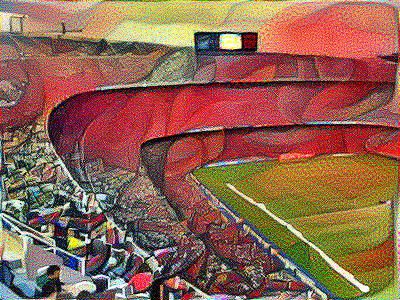

In [49]:
p = x.reshape((height, width, 3))
p = p[:, :, ::-1]
p[:, :, 0] += 103.939
p[:, :, 1] += 116.779
p[:, :, 2] += 123.68
p = np.clip(p, 0, 255).astype('uint8')
Image.fromarray(p)

In [0]:
p = x.reshape((height, width, 3))

p = np.clip(p, 0, 255).astype('uint8')


In [52]:
from scipy.misc import imsave
imsave('sloth_sketch.jpg', p)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


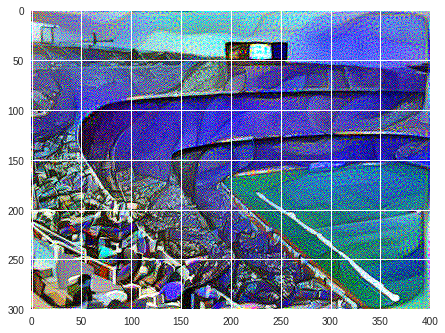

In [53]:
import matplotlib.pyplot as plt
plt.imshow(p)